# Change working directory as needed and use my version of the What.py file

In [1]:
%cd /Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks

/Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks


In [2]:
import os
import imageio
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pygame
from psychopy import visual, core, event, gui, data

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST, MotionCloudNoise
import MotionClouds as mc

from main import init
args = init(filename='../data/2019-06-12') # pas de drop out!
print(args)


pygame 2.0.1 (SDL 2.0.14, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 10000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'what_offset_std': 15, 'what_offset_max': 25, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 0.75, 'contrast': 0.7, 'sf_0': 0.1, 'B_sf': 0.1, 'do_mask': True, 'N_theta': 6, 'N_azimuth': 24, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 1000, 'dim2': 1000, 'lr': 0.005, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.3, 'epochs': 60, 'num_processes': 1, 'no_cuda': False, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-06-12', 'seed': 2019, 'N_cv': 10, 'do_compute': True, 'save_model': True}


In [39]:
## Unit tests

#transforms.GaussianBlur(kernel_size = 1, sigma=(0.1, 2.0))
transform=transforms.Compose([
                               WhatShift(args,i_offset=0, j_offset=0),
                               WhatBackground(contrast = args.contrast,
                                              noise=0, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

data, label = next(iter(train_loader))
%timeit data, label = next(iter(train_loader))
print(label.shape)
print(data.shape)

574 ms ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
torch.Size([100])
torch.Size([100, 1, 128, 128])


# Adding Mutiple Digits to One Image

In [40]:
def random_roll(data, x_shift, y_shift):
    return np.roll(np.roll(data, x_shift, axis = 0), y_shift, axis = 1)

In [41]:
def numbers(data):
    num = [
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(-50,-20)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(0,20))]
    np.random.shuffle(num)
    return np.max((num[0:random.randint(1,9)]),axis = 0)

In [42]:
def add(data):
    data = data.numpy().reshape(100,128,128)
    return np.array([numbers(data) for i in range(100)]).reshape(100,128,128)

70.2 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(100, 128, 128)


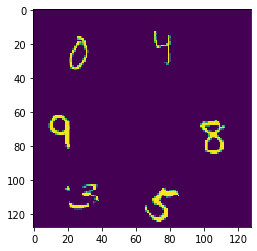

In [43]:
%timeit add(data)
data = add(data)
print(data.shape)
plt.imshow(data[0])

# Transform to RGBA, where Alpha channel has no transparency (A = 1)

In [44]:
def RGBA(data):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    alpha = np.ones((data.shape[0],128,128))
    return np.stack((data,data,data,alpha),axis=-1)

45.6 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(100, 128, 128, 4)


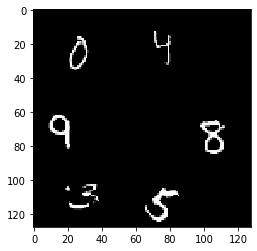

In [45]:
%timeit RGBA(data)
data = RGBA(data)
print(data.shape)
plt.imshow(data[0])

# Add "Motion" One Image generated 60 times = 1 second

In [46]:
def motion(data,background):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    background = np.reshape(RGBA(background),(128,128,4))
    return np.swapaxes(
        np.moveaxis(
            np.array([[
                np.max((
                    np.roll(background,back,axis =(0,1)),data[D,:,:,:]),axis=0) 
                for back in range(60)] 
                for D in range(data.shape[0])]),(0,1,2,3,4),(0,1,4,3,2)),3,4)

2.24 ms ± 96.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(128, 128, 1)


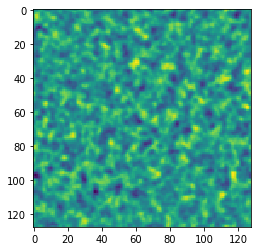

In [47]:
%timeit z, env = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf, alpha=.0, N_pic=128, seed=42, motion = True)
z, env = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf, alpha=.0, N_pic=128, seed=42, motion = True)
print(z.shape)
plt.imshow(z[:,:,0])

14.4 s ± 3.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
(100, 60, 4, 128, 128)


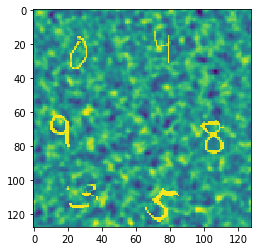

In [48]:
%timeit motion(data,np.moveaxis(z,(0,1,2),(2,1,0)))
data = motion(data,np.moveaxis(z,(0,1,2),(2,1,0)))
print(data.shape)
plt.imshow(data[0,0,0,:,:])

# Add transparency ( 0 =< Alpha channel =< 1)

In [49]:
def transparency(data):
    [[[np.put(img[frame,3,row,:],np.where(img[frame,0,row,:]>0.9),np.linspace(0, 1, num=60)[frame]) 
       for row in range(128)] 
      for frame in range(60)] for img in data]

31.8 s ± 3.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
(100, 60, 4, 128, 128)


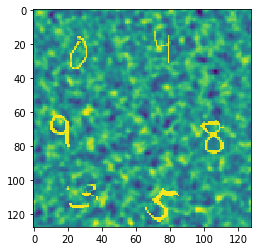

In [50]:
%timeit transparency(data)
transparency(data)
print(data.shape)
plt.imshow(data[0,0,0,:,:])

# Lights, Camera, Action !!!

In [12]:
instructions = """
At each trial you see a series of textured images, report if you 
spot a specific digit by pressing the space bar.

Press the space bar to begin the experiment.

"""

win = visual.Window(winType = 'pyglet', size =(800,800), colorSpace = "rgb")

message = visual.TextStim(win, text= instructions)
message.autoDraw = True  # Automatically draw every frame
win.flip()
core.wait(5.0)
message.text = ''  # Change properties of existing stim
win.flip()
core.wait(0.0)

# Infinte loop so you'll have to stop it
while True:
    for i in range(data.shape[0]-1):
            mov = data[i]
            for ii in range(mov.shape[0]):
                movie_clip = visual.ImageStim(win, np.moveaxis(mov[ii],(0,1,2),(2,1,0)), colorSpace = "rgb", contrast = 1, size = 2, flipVert=True)
                movie_clip.draw()
                win.flip()

KeyboardInterrupt: 